In [1]:
# Useful for debugging
%load_ext autoreload
%autoreload 2

from matplotlib import pyplot as plt
import matplotlib 
import os
import yaml

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import sys, os
import numpy as np
root = os.path.join(os.getcwd())

# Distgen 
---

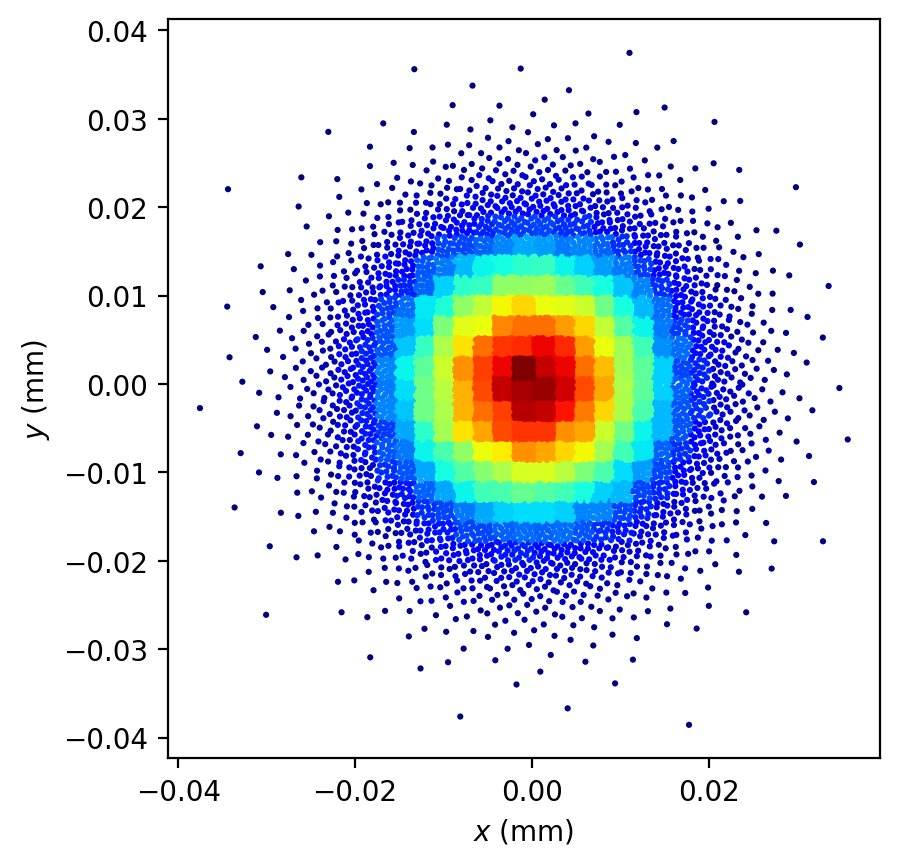

In [2]:
from distgen import Generator
from distgen.plot import plot_dist2d, plot_dist1d

DISTGEN_INPUT_FILE = os.path.join(root,'templates/tesla_9cell_cavity/distgen.in.yaml')
gen = Generator(DISTGEN_INPUT_FILE)
beam = gen.beam()

plot_dist2d(beam, 'x', 'mm', 'y', 'mm', axis='equal');

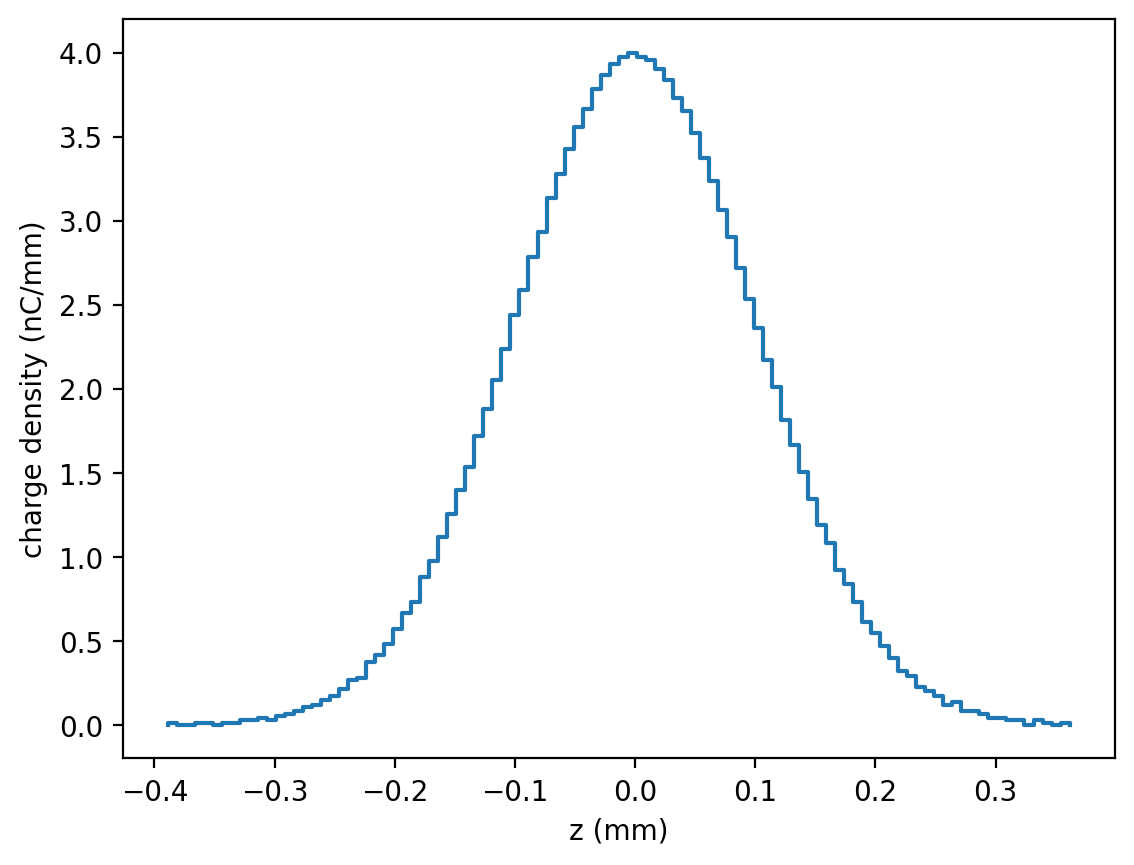

In [3]:
plot_dist1d(beam, 'z', 'mm')

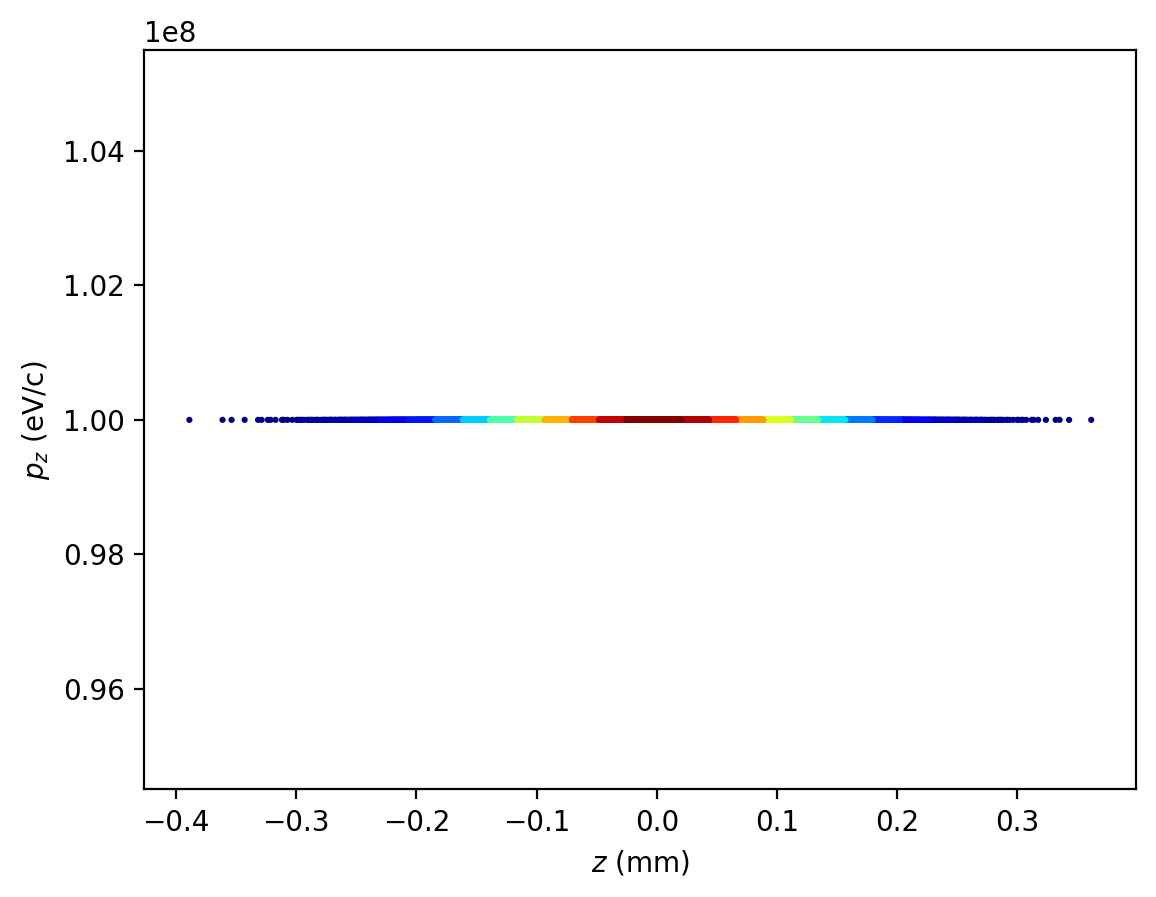

In [4]:
plot_dist2d(beam, 'z', 'mm', 'pz', 'eV/c');

# GPT input file:

In [5]:
GPT_INPUT_FILE = os.path.join(root,'templates/tesla_9cell_cavity/gpt.in')

# Run GPT without phasing
---

In [6]:
from gpt.gpt_distgen import run_gpt_with_distgen

settings={'n_particle':10000, 
          'Ntout':500,
          'field_scale':32000000.0,
          'space_charge':0}

G1 = run_gpt_with_distgen(settings,gpt_input_file=GPT_INPUT_FILE,
                          distgen_input_file=DISTGEN_INPUT_FILE,
                          verbose=True,
                          gpt_verbose=False,
                          auto_phase=True)

print(G1)

Run GPT with Distgen:
n_particle is in distgen
Replacing param n_particle with value 10000
Ntout is in gpt
field_scale is in gpt
space_charge is in gpt
Linking particle files, distgen output will point to -> "gpt.particles.gdf" in working directory.

Distgen >------

Distribution format: gpt
Output file: /var/folders/w8/8n1md1352pzd3nqp0lhc5jy00000gn/T/tmph5r2qo8p/gpt.particles.gdf

Creating beam distribution....
   Beam starting from: time
   Total charge: 1 nC.
   Number of macroparticles: 10000.
   Assuming cylindrical symmetry...
   r distribution: radial Gaussian
   theta distribution: uniform theta
      min_theta = 0 rad, max_theta = 6.28319 rad
   z distribution: Gaussian
      avg_z = 0 mm, sigma_z = 0.100 mm
   Shifting avg_x = -5.76994E-06 mm -> 0 mm
   Scaling sigma_x = 0.00998699 mm -> 0.01 mm
   Shifting avg_y = -1.45535E-06 mm -> 0 mm
   Scaling sigma_y = 0.00999866 mm -> 0.01 mm
   Shifting avg_z = -0.000131838 mm -> 0 mm
   Scaling sigma_z = 0.0999276 mm -> 0.1 mm
   T

In [7]:
from impact import Impact
I = Impact()
I.load_archive('../../impact_cavity9_SC_OFF.h5')
I.particles

ModuleNotFoundError: No module named 'impact'

In [ ]:
fig, ax = plt.subplots(1,3, sharex='col', constrained_layout=True, figsize=[12, 4])

avgz = 'mean_z'
ke='mean_kinetic_energy'

ax[0].plot(G1.stat('mean_z','tout'), G1.stat(ke,'tout')/1e6,  I.stat('mean_z'), I.stat(ke)/1e6);
ax[0].set_xlabel('z (m)');
ax[0].set_ylabel('KE (MeV)');
ax[0].legend(['GPT','Impact']);
ax[0].set_title('No Space Charge');

stdx='sigma_x'
ax[1].plot(G1.stat('mean_z','tout'), G1.stat(stdx,'tout')*1e6, I.stat('mean_z'), I.stat(stdx)*1e6);
ax[1].set_xlabel('z (m)');
ax[1].set_ylabel(r'$\sigma_{x,y}$ ($\mu$m)');
ax[1].legend(['GPT','Impact']);
ax[1].set_title('No Space Charge');

stdz='sigma_z'
ax[2].plot(G1.stat('mean_z','tout'), G1.stat(stdz,'tout')*1e6, I.stat('mean_z'), I.stat(stdz)*1e6);
ax[2].set_xlabel('z (m)');
ax[2].set_ylabel(r'$\sigma_{z}$ ($\mu$m)');
ax[2].legend(['GPT','Impact']);


In [ ]:
settings={'n_particle':10000, 
          'Ntout':500,
          'field_scale':32000000.0,
          'space_charge':1}

G2 = run_gpt_with_distgen(settings,gpt_input_file=GPT_INPUT_FILE,
                          distgen_input_file=DISTGEN_INPUT_FILE,
                          verbose=True,
                          gpt_verbose=False,
                          auto_phase=True)

print(G2)

In [ ]:
z_tout = 1.5

from astra import Astra

I2 = Impact()
I2.load_archive('../../impact_cavity9_SC_ON.h5')

A2dsc = Astra()
A2dsc.load_archive('../../astra_cavity9_SC_2D.h5')

A3dsc = Astra()
A3dsc.load_archive('../../astra_cavity9_SC_3D.h5')

ap2d = A2dsc.particles[-1]
ap3d = A3dsc.particles[-1]

avgz_tout = G2.stat('mean_z','tout')
at_screen = np.where(avgz_tout-1.5 == np.min(np.abs(avgz_tout-1.5)))[0][0]

plt.plot(G2.tout[at_screen]['delta_z'][::10]*1e3, G2.tout[at_screen]['delta_pz'][::10]/1e3, '.', alpha=0.3);
plt.plot(ifp['delta_z'][::10]*1e3, ifp['delta_pz'][::10]/1e3,'*', alpha=0.3);
plt.plot(ap2d['delta_z'][::10]*1e3, ap2d['delta_pz'][::10]/1e3,'x', alpha=0.3);
plt.plot(ap3d['delta_z'][::10]*1e3, ap3d['delta_pz'][::10]/1e3,'s', alpha=0.3);
plt.xlabel('$\Delta z$ (mm)');
plt.ylabel('$\Delta p_z$ (keV)');
plt.title('Space Charge ON');
plt.legend(['GPT','Impact','ASTRA 2D', 'ASTRA 3D']);

In [ ]:
plt.plot(G2.stat('mean_z','tout'), G2.stat('norm_emit_x','tout')*1e9);
plt.plot(I2.stat('mean_z'), I2.stat('norm_emit_x')*1e9);
plt.plot(A2dsc.stat('mean_z'), A2dsc.stat('norm_emit_x')*1e9);
plt.plot(A3dsc.stat('mean_z'), A3dsc.stat('norm_emit_x')*1e9);
plt.xlabel('z (mm)');
plt.ylabel('$\epsilon_{n,x}$ (nm)');
plt.title('Space Charge ON');
plt.legend(['GPT', 'Impact', 'ASTRA 2D', 'ASTRA 3D']);

In [ ]:
# Some how this fixes CM's map?!?

path = '/Users/colwyngulliford/Documents/GitHub/lume-gpt/templates/tesla_9cell_cavity/'
data = np.loadtxt(os.path.join(path, 'tesla_9cell_cavity_for_gpt.txt'), skiprows=1)
f=open(os.path.join(path, 'tesla_9cell_cavity_for_gpt.txt'),'r')
header = f.readline()
np.savetxt('../templates/tesla_9cell_cavity/new9cell.txt', data, header=header, comments=' ')